In [1]:
!pip install scikit-learn imbalanced-learn scikit-optimize shap matplotlib seaborn pandas

     ---------------------------------------- 11.1/11.1 MB 8.5 MB/s eta 0:00:00
     -------------------------------------- 238.4/238.4 kB 5.0 MB/s eta 0:00:00
     -------------------------------------- 107.8/107.8 kB 6.1 MB/s eta 0:00:00
     ------------------------------------- 489.6/489.6 kB 10.2 MB/s eta 0:00:00
     ---------------------------------------- 8.1/8.1 MB 8.4 MB/s eta 0:00:00
     -------------------------------------- 294.9/294.9 kB 8.9 MB/s eta 0:00:00
     ---------------------------------------- 11.6/11.6 MB 8.6 MB/s eta 0:00:00
     ------------------------------------ 301.8/301.8 kB 718.2 kB/s eta 0:00:00
     ---------------------------------------- 12.9/12.9 MB 5.6 MB/s eta 0:00:00
     ---------------------------------------- 41.2/41.2 MB 7.7 MB/s eta 0:00:00
     ---------------------------------------- 78.5/78.5 kB 4.6 MB/s eta 0:00:00
     ---------------------------------------- 2.8/2.8 MB 10.6 MB/s eta 0:00:00
     --------------------------------------

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve, auc, precision_recall_curve
from imblearn.over_sampling import SMOTE
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
import shap
import warnings
warnings.filterwarnings('ignore')

c:\John\Universidad\Materias\Semestre 3\MLOps\Ejercicio Churn\my-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Simular dataset churn
df = pd.read_csv("C:/John/Universidad/Materias/Semestre 3/MLOps/Ejercicio Churn/WA_Fn-UseC_-Telco-Customer-Churn.csv")  # Asegúrate de tener este archivo en tu entorno

df = df.dropna()
df['ChurnTarget'] = df['Churn'].apply(lambda x: 1 if x=='Yes' else 0)
df = pd.get_dummies(df, drop_first=True)

In [4]:
X = df.drop(["ChurnTarget","Churn_Yes"], axis=1)
y = df["ChurnTarget"]

print(f"Porcentaje de churn positivo: {y.mean():.2%}")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

Porcentaje de churn positivo: 26.54%


In [5]:
print('🔄 Randomized Search iniciado...')
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced', 'balanced_subsample'],
    'bootstrap': [True, False]
}

rscv = RandomizedSearchCV(RandomForestClassifier(random_state=42), param_distributions=param_dist,
                          n_iter=20, cv=3, scoring='roc_auc', random_state=42, n_jobs=-1, verbose=1)
rscv.fit(X_train, y_train)

print("🏁 Mejor configuración (Random Search):", rscv.best_params_)
print("🔍 AUC test:", roc_auc_score(y_test, rscv.predict_proba(X_test)[:,1]))
print(classification_report(y_test, rscv.predict(X_test)))

🔄 Randomized Search iniciado...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
🏁 Mejor configuración (Random Search): {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None, 'class_weight': 'balanced', 'bootstrap': False}
🔍 AUC test: 0.83306457540842
              precision    recall  f1-score   support

           0       0.86      0.85      0.86      1552
           1       0.60      0.62      0.61       561

    accuracy                           0.79      2113
   macro avg       0.73      0.74      0.73      2113
weighted avg       0.79      0.79      0.79      2113



In [6]:
print('🔄 Grid Search iniciado...')
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'class_weight': ['balanced'],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

gscv = GridSearchCV(RandomForestClassifier(random_state=42), param_grid=param_grid,
                    scoring='roc_auc', cv=3, n_jobs=-1, verbose=1)
gscv.fit(X_train, y_train)

print("🏁 Mejor configuración (Grid Search):", gscv.best_params_)
print("🔍 AUC test:", roc_auc_score(y_test, gscv.predict_proba(X_test)[:,1]))
print(classification_report(y_test, gscv.predict(X_test)))

🔄 Grid Search iniciado...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
🏁 Mejor configuración (Grid Search): {'class_weight': 'balanced', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
🔍 AUC test: 0.816560082327214
              precision    recall  f1-score   support

           0       0.91      0.68      0.78      1552
           1       0.48      0.82      0.60       561

    accuracy                           0.72      2113
   macro avg       0.70      0.75      0.69      2113
weighted avg       0.80      0.72      0.73      2113



In [7]:
print('🔄 Bayesian Optimization iniciado...')
opt_space = {
    'n_estimators': Integer(100, 300),
    'max_depth': Integer(5, 30),
    'min_samples_split': Integer(2, 10),
    'min_samples_leaf': Integer(1, 5),
    'max_features': Categorical(['sqrt', 'log2']),
    'class_weight': Categorical(['balanced', 'balanced_subsample']),
    'bootstrap': Categorical([True, False])
}

bsearch = BayesSearchCV(RandomForestClassifier(random_state=42),
                        search_spaces=opt_space,
                        n_iter=20,
                        scoring='roc_auc',
                        cv=3,
                        n_jobs=-1,
                        verbose=1,
                        random_state=42)
bsearch.fit(X_train, y_train)

print("🏁 Mejor configuración (Bayesian Search):", bsearch.best_params_)
print("🔍 AUC test:", roc_auc_score(y_test, bsearch.predict_proba(X_test)[:,1]))
print(classification_report(y_test, bsearch.predict(X_test)))

🔄 Bayesian Optimization iniciado...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for 

In [8]:
print('🔁 Aplicando SMOTE...')
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

rf_sm = RandomForestClassifier(**rscv.best_params_, random_state=42)
rf_sm.fit(X_train_sm, y_train_sm)

print("✅ Resultados con SMOTE")
print("🔍 AUC test:", roc_auc_score(y_test, rf_sm.predict_proba(X_test)[:,1]))
print(classification_report(y_test, rf_sm.predict(X_test)))

🔁 Aplicando SMOTE...
✅ Resultados con SMOTE
🔍 AUC test: 0.8328566900049617
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1552
           1       0.67      0.48      0.56       561

    accuracy                           0.80      2113
   macro avg       0.75      0.70      0.72      2113
weighted avg       0.79      0.80      0.79      2113



📊 Visualizaciones iniciadas...


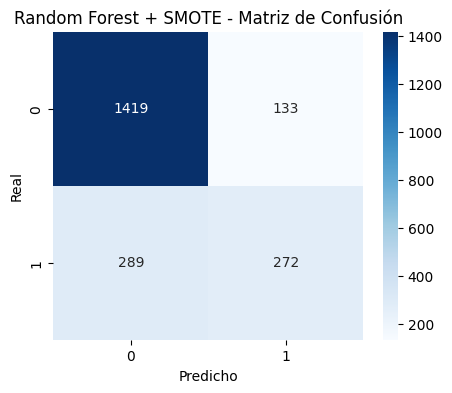

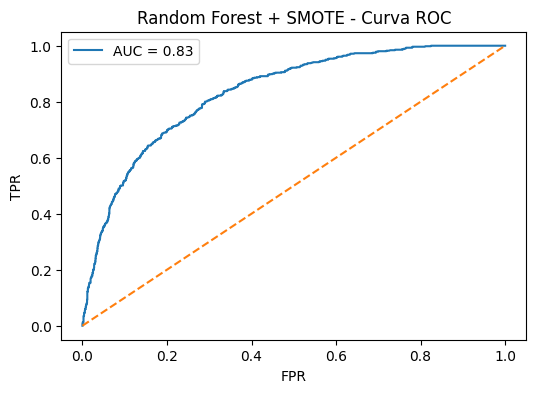

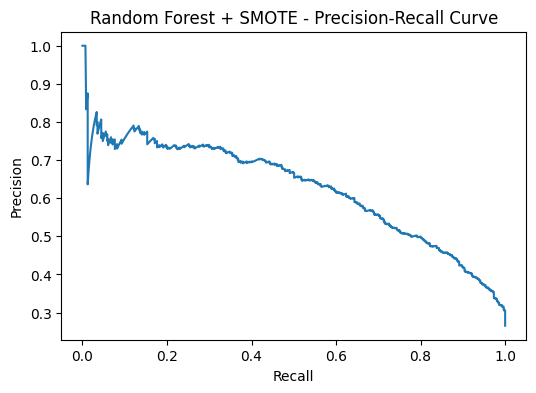

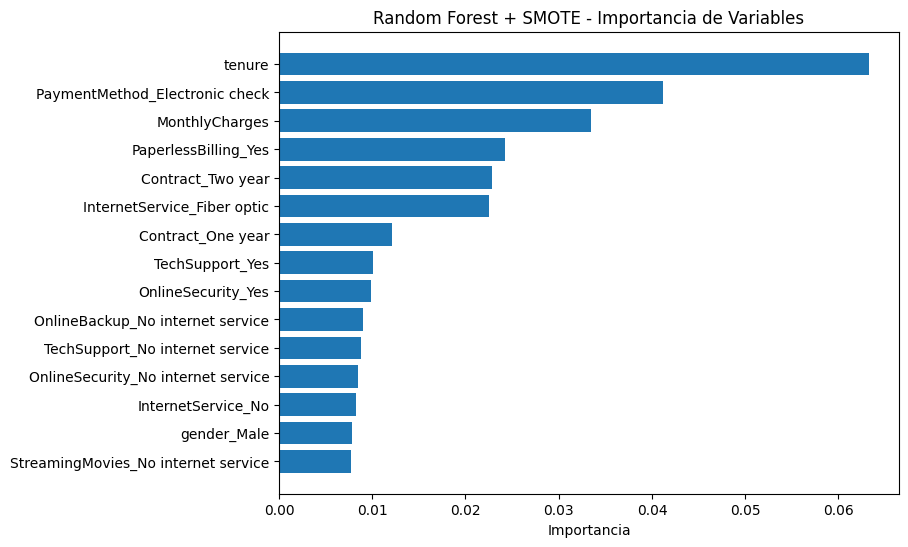

In [9]:
print('📊 Visualizaciones iniciadas...')
def plot_model_performance(model, X_test, y_test, model_name="Modelo"):
    y_pred = model.predict(X_test)
    y_scores = model.predict_proba(X_test)[:, 1]

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
    plt.title(f"{model_name} - Matriz de Confusión")
    plt.xlabel("Predicho")
    plt.ylabel("Real")
    plt.show()

    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.title(f"{model_name} - Curva ROC")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.legend()
    plt.show()

    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision)
    plt.title(f"{model_name} - Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.show()

def plot_feature_importance(model, feature_names, top_n=15, model_name="Modelo"):
    importances = model.feature_importances_
    indices = np.argsort(importances)[-top_n:]
    plt.figure(figsize=(8, 6))
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel("Importancia")
    plt.title(f"{model_name} - Importancia de Variables")
    plt.show()

plot_model_performance(rf_sm, X_test, y_test, model_name="Random Forest + SMOTE")
plot_feature_importance(rf_sm, X.columns, top_n=15, model_name="Random Forest + SMOTE")

In [16]:
X_train = X_train.astype(np.float64, errors='raise')  # Fallará si hay valores no convertibles
X_test = X_test.astype(np.float64, errors='raise')

🧠 Interpretabilidad con SHAP...


100%|===================| 4223/4226 [30:16<00:01]        

<Figure size 640x480 with 0 Axes>

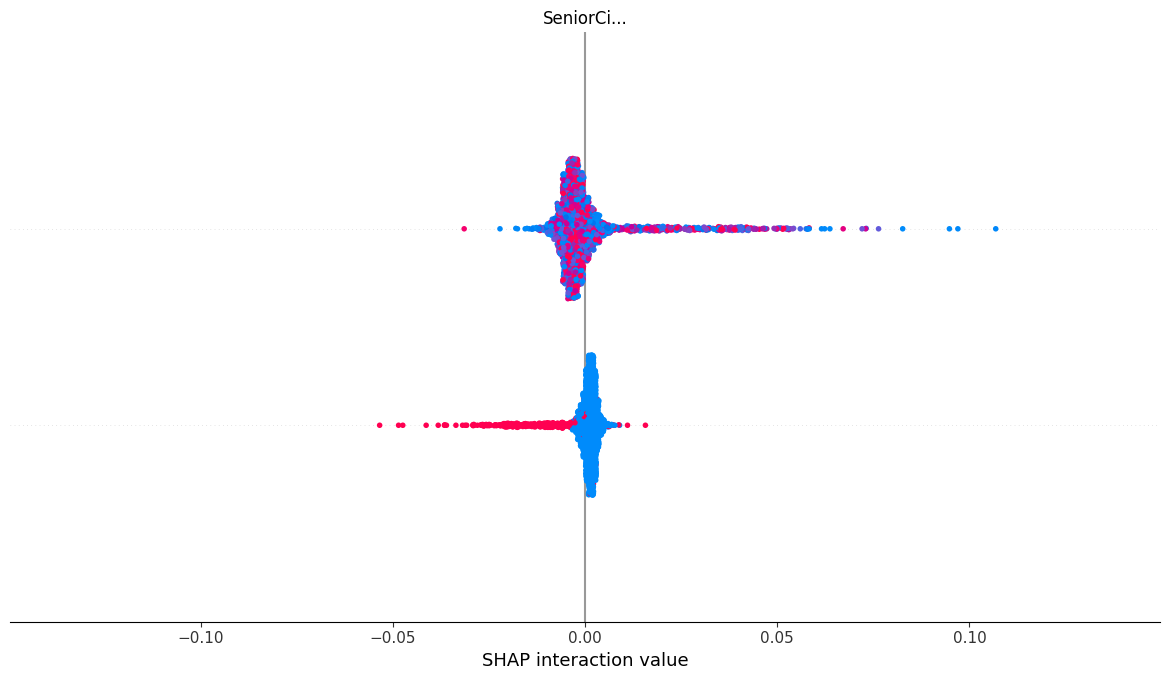

<Figure size 640x480 with 0 Axes>

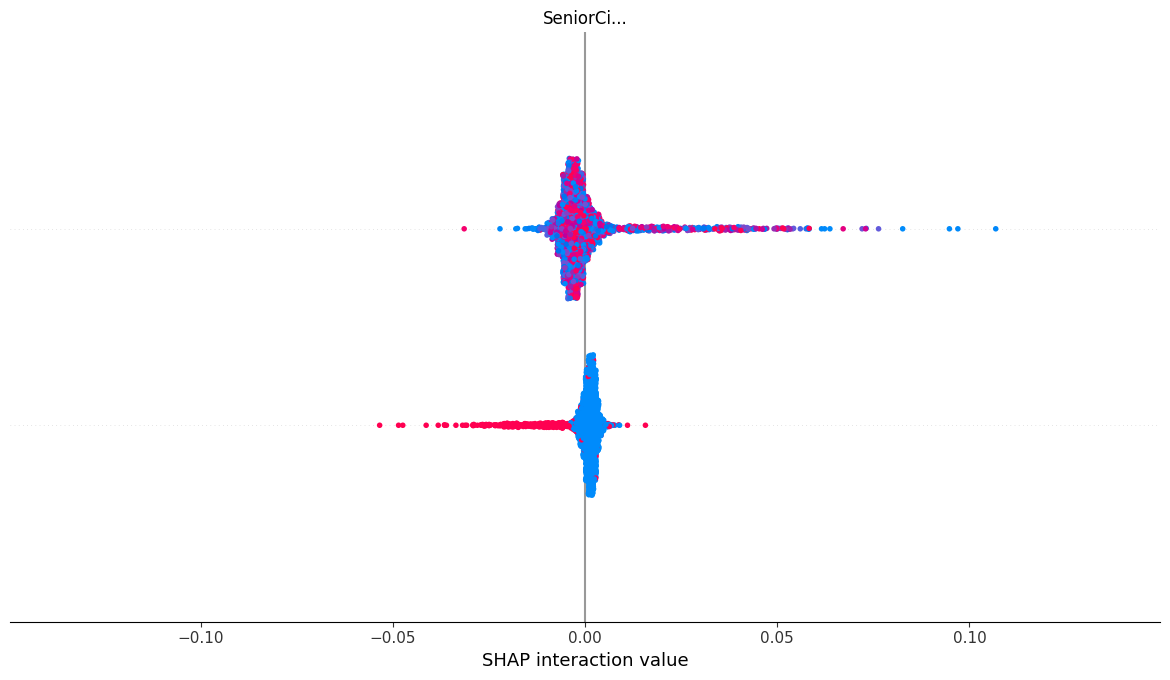

In [17]:
print('🧠 Interpretabilidad con SHAP...')
explainer = shap.Explainer(rf_sm, X_train, feature_names=X.columns)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar", show=True)
shap.summary_plot(shap_values, X_test, show=True)